<a href="https://colab.research.google.com/github/Begizew2112/10academykifiya-AIM-week0/blob/main/sene3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Dropout # Add all specific layers
from tensorflow.keras.optimizers import Adam # Add all specific optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Add all specific callbacks
from tensorflow.keras.regularizers import l2 # If using l2 directly
from tensorflow.keras.metrics import RootMeanSquaredError

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 1. Load Data & Initial Checks ---
data_path = '/content/drive/MyDrive/reduced10*6.csv'  # use actual filename, not wildcard

try:
    df_loaded = pd.read_csv(data_path, index_col=0)
    print(f"Successfully loaded data from {data_path}. Shape: {df_loaded.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at {data_path}")
    raise

original_feature_cols = ['x_direction', 'y_direction', 'bearing_temperature', 'env_temperature']
target_col_name = 'RUL'


Mounted at /content/drive
Successfully loaded data from /content/drive/MyDrive/reduced10*6.csv. Shape: (1000000, 4)


In [6]:

#reduce the data size for sampling
# Check the length
original_len = len(df_loaded)
target_len = 200_000

# Downsample by selecting every N-th row
step = original_len // target_len
df_downsampled = df_loaded.iloc[::step]

# If it overshoots, trim to exactly 200,000 rows
df_loaded= df_downsampled.head(target_len)


In [7]:
df_loaded.head()

,x_direction,y_direction,bearing_temperature,env_temperature
0,-0.117601,-0.378231,41.614912,24.817354
1200,0.755253,0.303097,41.614912,24.817354
2400,0.347730,0.111551,41.614912,24.817354
3600,-0.356118,-1.037952,41.614912,24.817354
4800,0.373726,0.374173,41.603353,24.824984


In [8]:
# Verify columns exist
missing_csv_cols = [col for col in original_feature_cols if col not in df_loaded.columns]
if missing_csv_cols:
    raise ValueError(f"Missing specified feature columns in CSV: {missing_csv_cols}. Available: {df_loaded.columns.tolist()}")

print("\n--- Initial Data Head & Info ---")
print(df_loaded.head())
df_loaded.info()
print("\nInitial Descriptive Statistics:")
print(df_loaded[original_feature_cols].describe())
print("\nInitial NaNs per column:\n", df_loaded.isnull().sum())


--- Initial Data Head & Info ---
      x_direction  y_direction  bearing_temperature  env_temperature
0       -0.117601    -0.378231            41.614912        24.817354
1200     0.755253     0.303097            41.614912        24.817354
2400     0.347730     0.111551            41.614912        24.817354
3600    -0.356118    -1.037952            41.614912        24.817354
4800     0.373726     0.374173            41.603353        24.824984
<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 239998800
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   x_direction          199996 non-null  float64
 1   y_direction          199996 non-null  float64
 2   bearing_temperature  200000 non-null  float64
 3   env_temperature      200000 non-null  float64
dtypes: float64(4)
memory usage: 7.6 MB

Initial Descriptive Statistics:
         x_direction    y_direction  bearing_temperature  env_tem


--- Visualizing Initial Feature Distributions ---


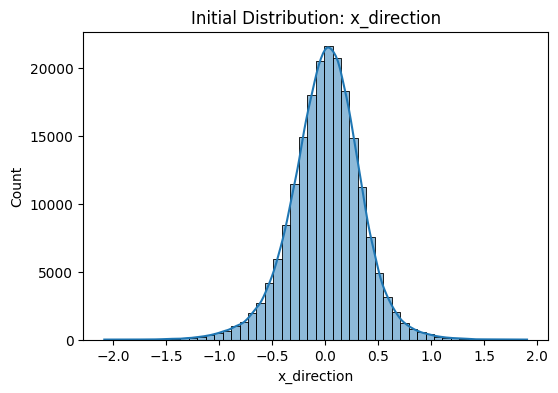

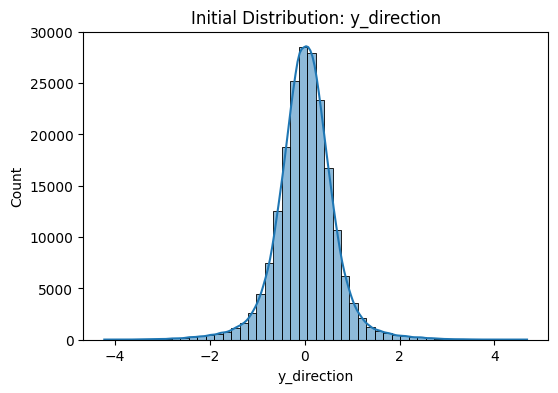

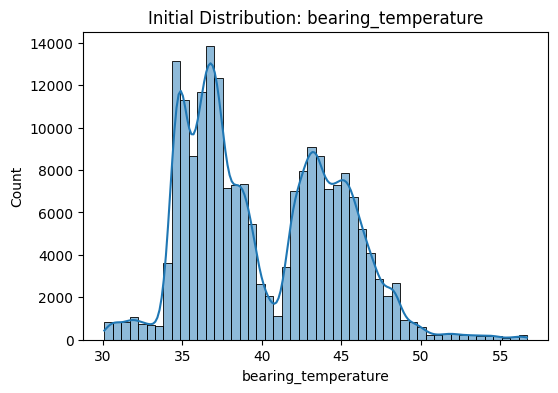

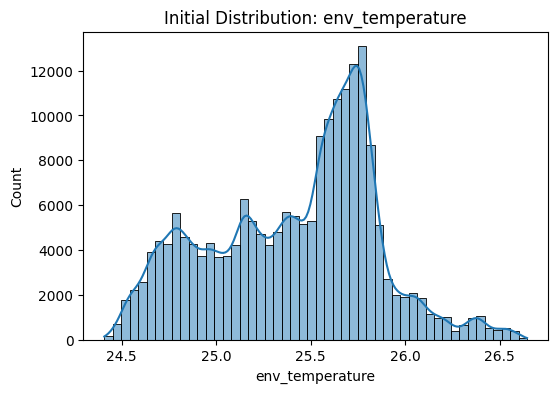


Dropped 4 rows due to NaNs in original feature columns.
Shape after initial NaN cleaning: (199996, 4)


In [9]:
# Visualize initial distributions of original features
print("\n--- Visualizing Initial Feature Distributions ---")
for col in original_feature_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_loaded[col].dropna(), kde=True, bins=50)
    plt.title(f'Initial Distribution: {col}')
    plt.show()

# --- 2. Initial NaN Cleaning ---
initial_rows = len(df_loaded)
df_cleaned_nans = df_loaded.dropna(subset=original_feature_cols).copy()
rows_dropped = initial_rows - len(df_cleaned_nans)
print(f"\nDropped {rows_dropped} rows due to NaNs in original feature columns.")
print(f"Shape after initial NaN cleaning: {df_cleaned_nans.shape}")
if df_cleaned_nans[original_feature_cols].isnull().any().any():
    raise ValueError("NaNs still present after initial dropna.")
df_working = df_cleaned_nans.copy()


--- Outlier Detection and Capping ---
Column 'x_direction': Bounds [-0.80, 0.82]. Outliers found: 5150 (2.58%)


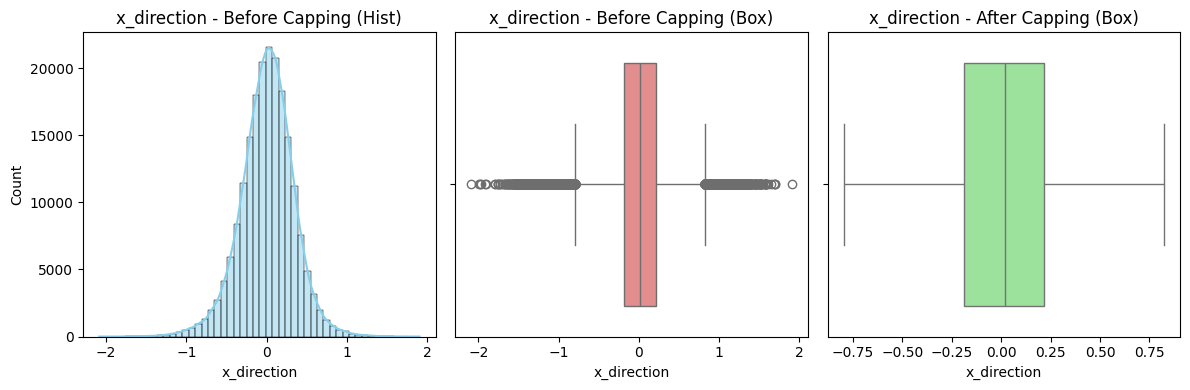

Column 'y_direction': Bounds [-1.32, 1.36]. Outliers found: 8247 (4.12%)


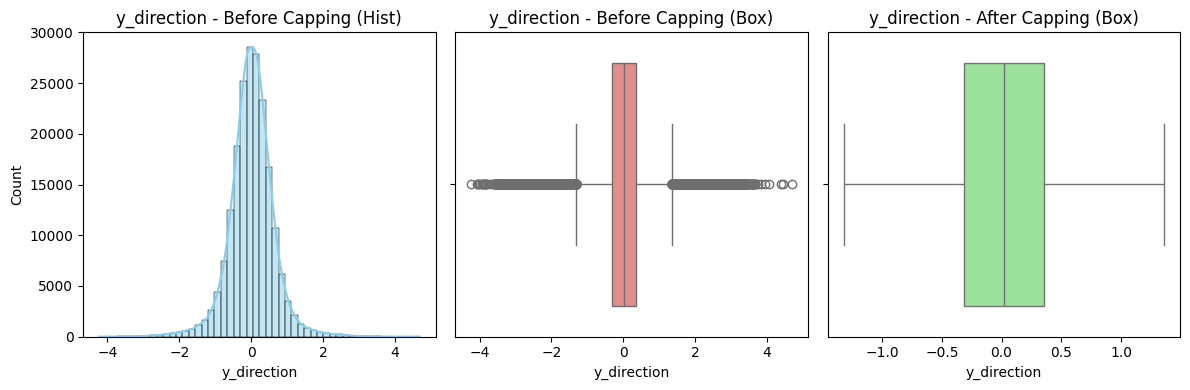

Column 'bearing_temperature': Bounds [24.84, 55.44]. Outliers found: 339 (0.17%)


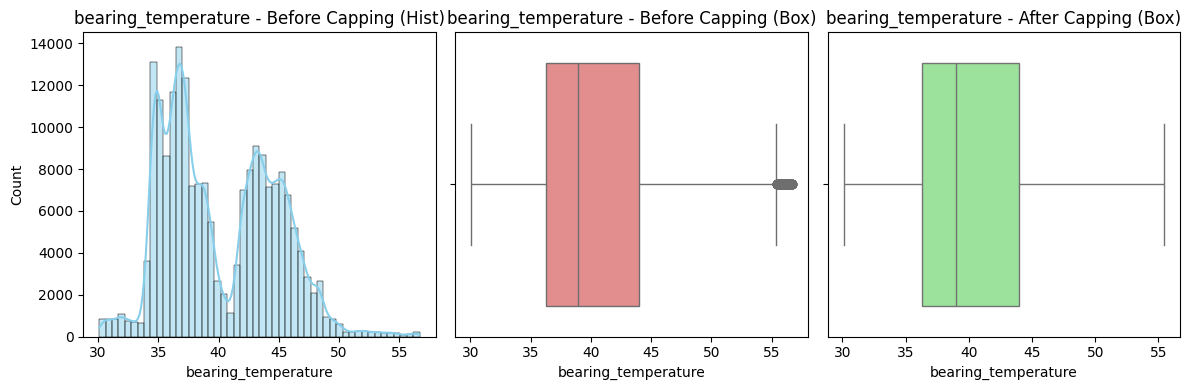

Column 'env_temperature': Bounds [24.09, 26.72]. Outliers found: 0 (0.00%)


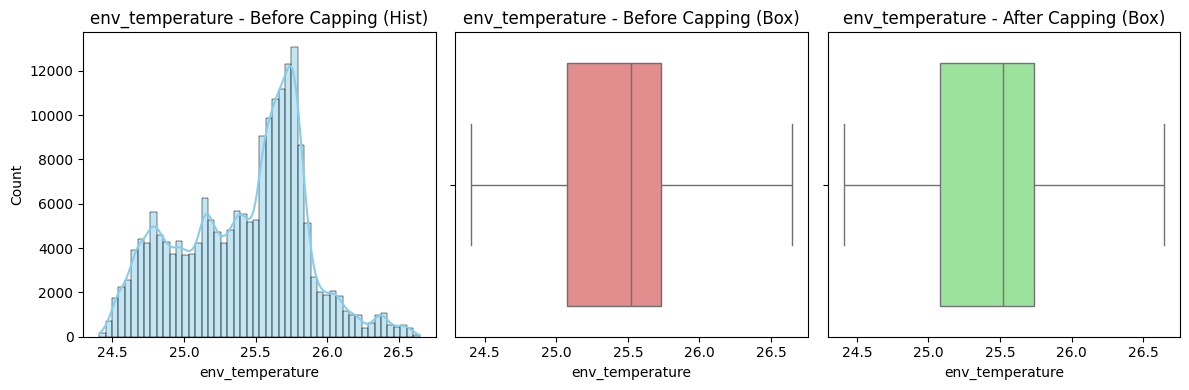

In [10]:
# --- 3. Outlier Treatment (IQR Capping) ---
print("\n--- Outlier Detection and Capping ---")
df_capped_outliers = df_working.copy()
for column in original_feature_cols:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(df_capped_outliers[column], kde=True, bins=50, color='skyblue')
    plt.title(f'{column} - Before Capping (Hist)')

    plt.subplot(1, 3, 2)
    sns.boxplot(x=df_capped_outliers[column], color='lightcoral')
    plt.title(f'{column} - Before Capping (Box)')

    Q1 = df_capped_outliers[column].quantile(0.25)
    Q3 = df_capped_outliers[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = ((df_capped_outliers[column] < lower_bound) | (df_capped_outliers[column] > upper_bound)).sum()
    print(f"Column '{column}': Bounds [{lower_bound:.2f}, {upper_bound:.2f}]. Outliers found: {outliers_count} ({(outliers_count/len(df_capped_outliers)*100):.2f}%)")

    df_capped_outliers[column] = np.clip(df_capped_outliers[column], lower_bound, upper_bound)

    plt.subplot(1, 3, 3)
    sns.boxplot(x=df_capped_outliers[column], color='lightgreen')
    plt.title(f'{column} - After Capping (Box)')
    plt.tight_layout()
    plt.show()

In [11]:
df_processed = df_capped_outliers.copy()
print("\n--- Data Description After Outlier Capping ---")
print(df_processed[original_feature_cols].describe())


# --- 4. Feature Engineering (Logarithmic & Absolute) ---
print("\n--- Feature Engineering ---")
epsilon = 1e-6 # For numerical stability with log

# Temperature
if (df_processed['bearing_temperature'] <= 0).any():
    min_temp = df_processed['bearing tem'].min()
    df_processed['bearing tem_adj_for_log'] = df_processed['bearing tem'] - min_temp + epsilon
    print(f"Adjusted 'bearing tem' for log by subtracting min ({min_temp:.2f}) and adding epsilon.")
else:
    df_processed['bearing tem_adj_for_log'] = df_processed['bearing_temperature']
df_processed['log_bearing tem'] = np.log(df_processed['bearing tem_adj_for_log'])


--- Data Description After Outlier Capping ---
         x_direction    y_direction  bearing_temperature  env_temperature
count  199996.000000  199996.000000        199996.000000    199996.000000
mean        0.009103       0.016107            40.130239        25.414865
std         0.318102       0.547713             4.626532         0.440309
min        -0.796194      -1.322400            30.095782        24.407889
25%        -0.188830      -0.316359            36.315924        25.077553
50%         0.018494       0.019283            38.967181        25.519146
75%         0.216080       0.354335            43.964624        25.734969
max         0.823444       1.360376            55.437673        26.644500

--- Feature Engineering ---


In [12]:

# Vibrations
df_processed['abs_x_direction'] = df_processed['x_direction'].abs()
df_processed['log_abs_x_direction'] = np.log(df_processed['abs_x_direction'] + epsilon)
df_processed['abs_y_direction'] = df_processed['y_direction'].abs()
df_processed['log_abs_y_direction'] = np.log(df_processed['abs_y_direction'] + epsilon)


In [13]:
df_processed.head()

,x_direction,y_direction,bearing_temperature,env_temperature,bearing tem_adj_for_log,log_bearing tem,abs_x_direction,log_abs_x_direction,abs_y_direction,log_abs_y_direction
0,-0.117601,-0.378231,41.614912,24.817354,41.614912,3.728459,0.117601,-2.140452,0.378231,-0.972248
1200,0.755253,0.303097,41.614912,24.817354,41.614912,3.728459,0.755253,-0.280701,0.303097,-1.193698
2400,0.347730,0.111551,41.614912,24.817354,41.614912,3.728459,0.347730,-1.056327,0.111551,-2.193266
3600,-0.356118,-1.037952,41.614912,24.817354,41.614912,3.728459,0.356118,-1.032490,1.037952,0.037251
4800,0.373726,0.374173,41.603353,24.824984,41.603353,3.728181,0.373726,-0.984229,0.374173,-0.983033


In [14]:
df_processed.columns

Index(['x_direction', 'y_direction', 'bearing_temperature', 'env_temperature',
       'bearing tem_adj_for_log', 'log_bearing tem', 'abs_x_direction',
       'log_abs_x_direction', 'abs_y_direction', 'log_abs_y_direction'],
      dtype='object')

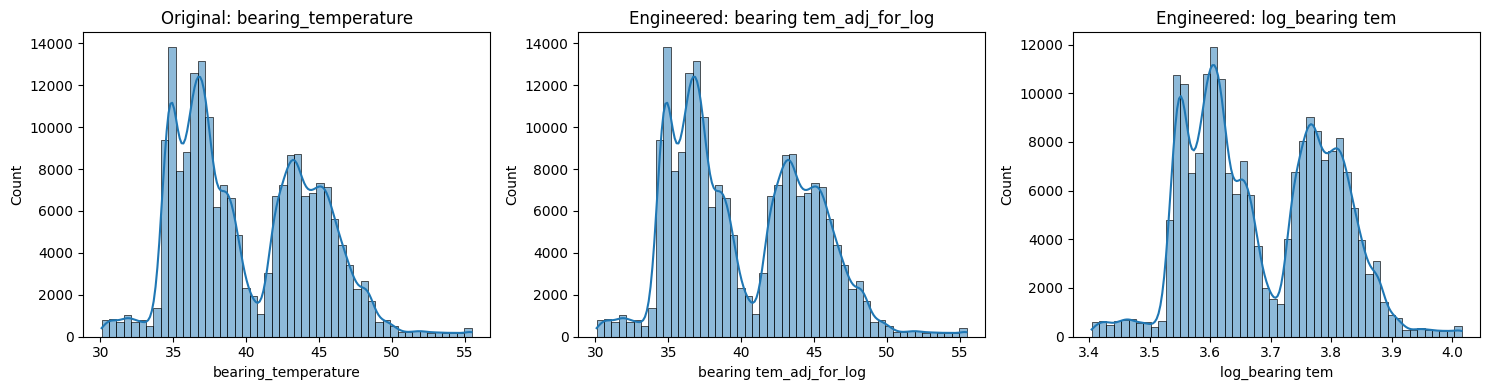

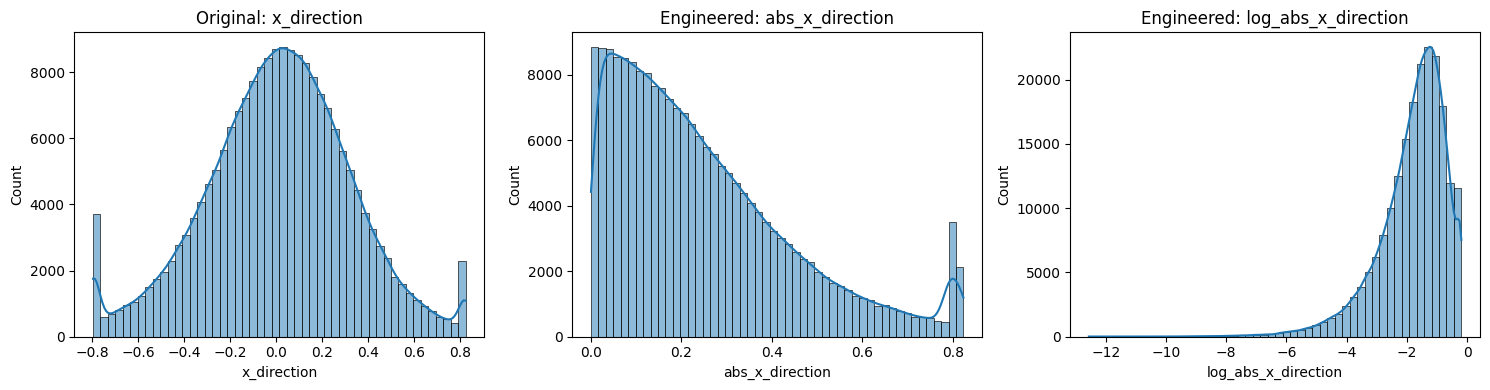

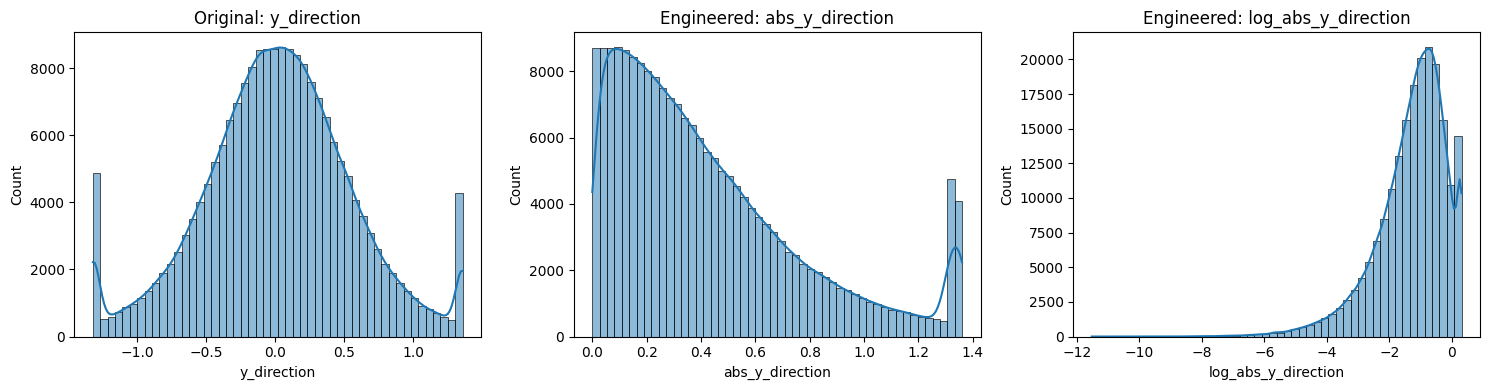

In [15]:
# Visualize original vs. engineered features
engineered_feature_map = {
    'bearing_temperature': ['bearing tem_adj_for_log', 'log_bearing tem'],
    'x_direction': ['abs_x_direction', 'log_abs_x_direction'],
    'y_direction': ['abs_y_direction', 'log_abs_y_direction']
}
for orig_col, eng_cols_list in engineered_feature_map.items():
    num_plots = len(eng_cols_list) + 1
    plt.figure(figsize=(5 * num_plots, 4))
    plt.subplot(1, num_plots, 1)
    sns.histplot(df_processed[orig_col], kde=True, bins=50)
    plt.title(f'Original: {orig_col}')
    for i, eng_col in enumerate(eng_cols_list):
        plt.subplot(1, num_plots, i + 2)
        sns.histplot(df_processed[eng_col], kde=True, bins=50)
        plt.title(f'Engineered: {eng_col}')
    plt.tight_layout()
    plt.show()

In [16]:
# Define final feature set
final_feature_cols = original_feature_cols + [
    'log_bearing tem', 'abs_x_direction', 'log_abs_x_direction',
    'abs_y_direction', 'log_abs_y_direction'
]
final_feature_cols = sorted(list(set(final_feature_cols))) # Ensure unique
print(f"\n--- Final selected features ({len(final_feature_cols)} features) ---")
print(final_feature_cols)



--- Final selected features (9 features) ---
['abs_x_direction', 'abs_y_direction', 'bearing_temperature', 'env_temperature', 'log_abs_x_direction', 'log_abs_y_direction', 'log_bearing tem', 'x_direction', 'y_direction']



--- Visualizing Feature Trends Over 'Cycle' (Before Scaling) ---


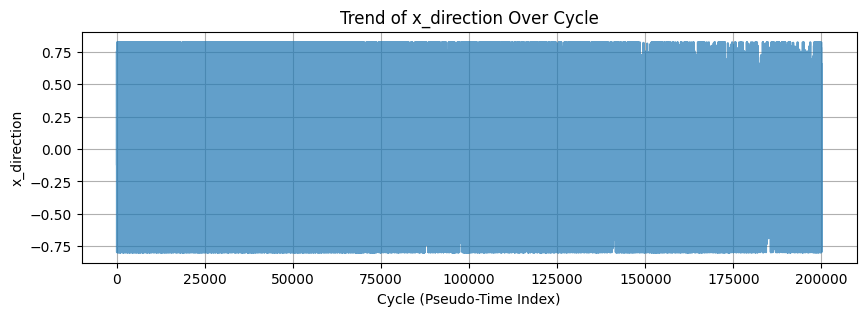

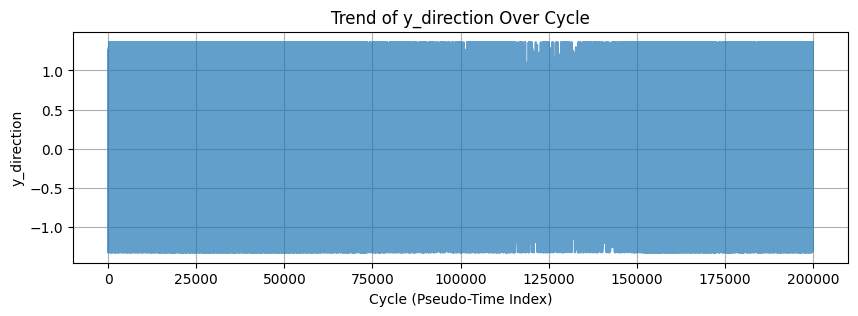

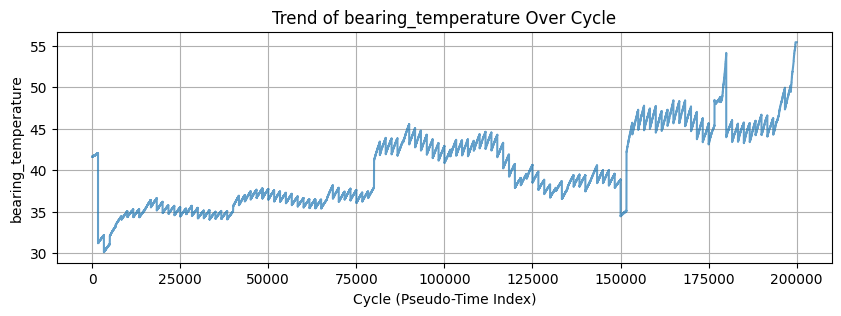

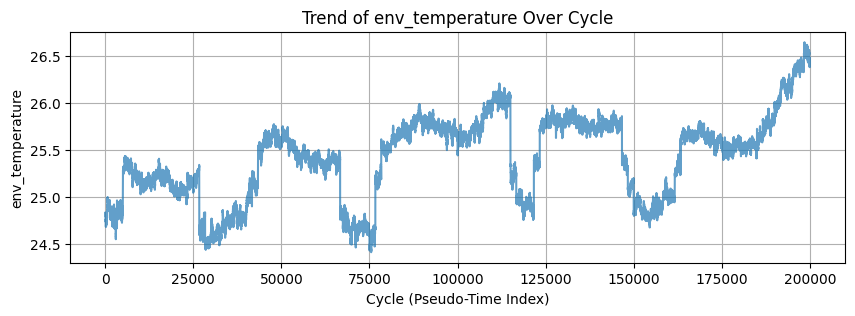

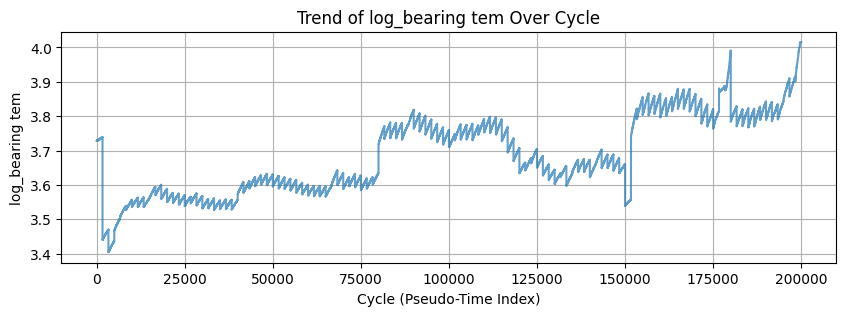

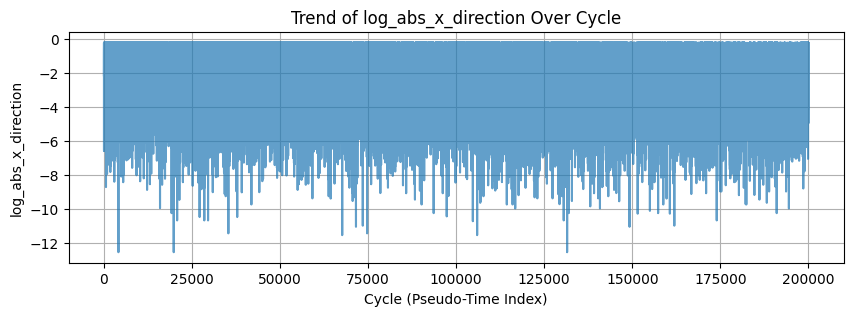

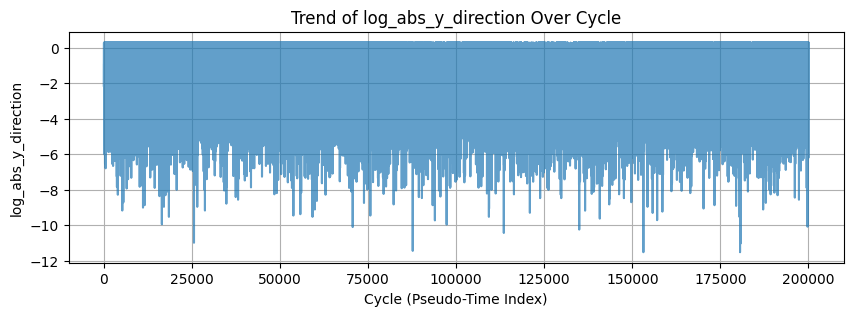

In [17]:

# --- 5. Add 'cycle' and Visualize Feature Trends Over Cycle ---
df_processed['cycle'] = range(len(df_processed)) # Represents pseudo-time
print("\n--- Visualizing Feature Trends Over 'Cycle' (Before Scaling) ---")
plot_cols_against_cycle = original_feature_cols + ['log_bearing tem', 'log_abs_x_direction', 'log_abs_y_direction']
for col in plot_cols_against_cycle:
    if col in df_processed.columns:
        plt.figure(figsize=(10, 3))
        plt.plot(df_processed['cycle'], df_processed[col], alpha=0.7)
        plt.xlabel('Cycle (Pseudo-Time Index)')
        plt.ylabel(col)
        plt.title(f'Trend of {col} Over Cycle')
        plt.grid(True)
        plt.show()



--- Correlation Analysis of Final Features ---


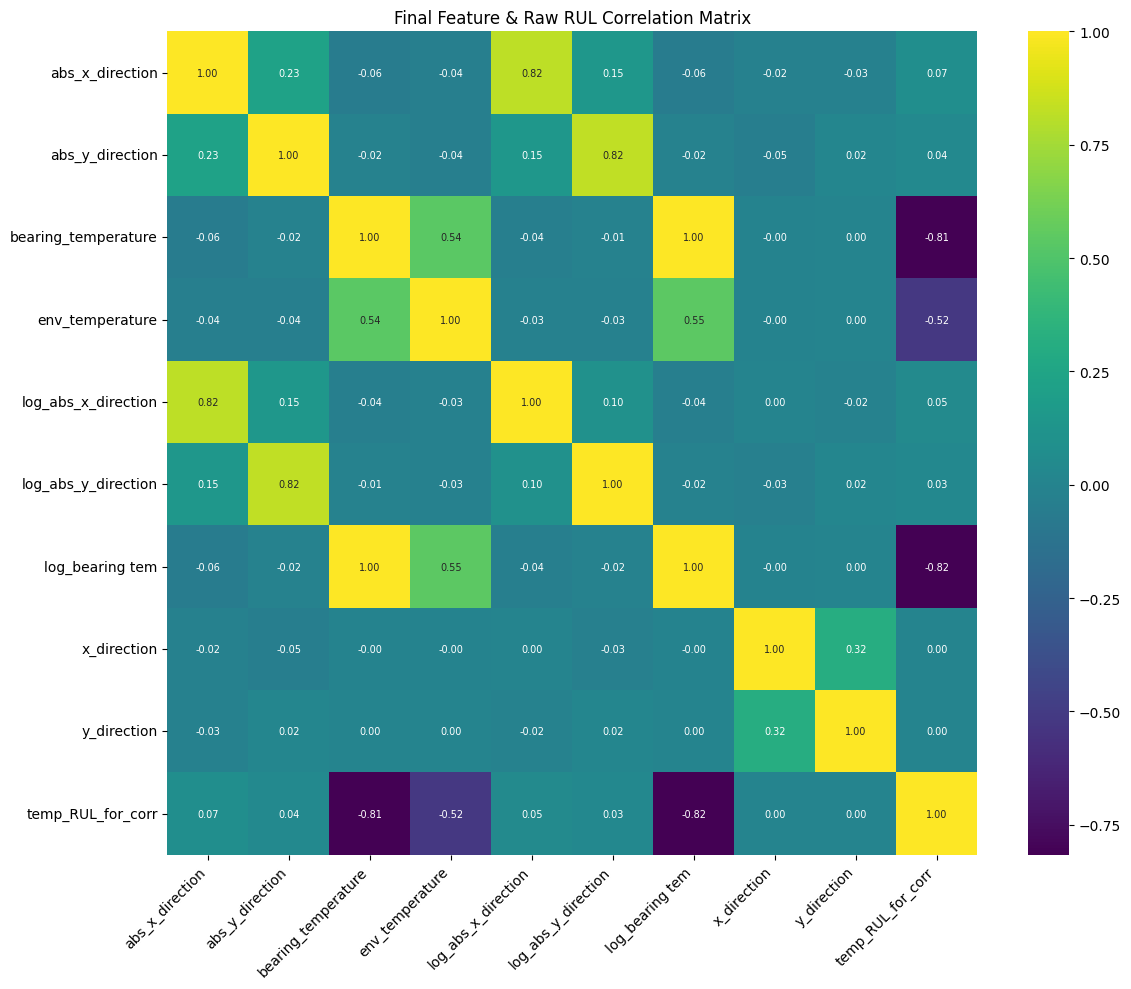

In [18]:

# --- 6. Correlation Analysis (on final features) ---
print("\n--- Correlation Analysis of Final Features ---")
# Temporarily add RUL before scaling to see its raw correlation with features
df_processed['temp_RUL_for_corr'] = df_processed.groupby('bearing_id')['cycle'].transform(lambda x: x.max() - x) if 'bearing_id' in df_processed.columns else (df_processed['cycle'].max() - df_processed['cycle'])

correlation_matrix_final = df_processed[final_feature_cols + ['temp_RUL_for_corr']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_final, annot=True, cmap='viridis', fmt=".2f", annot_kws={"size": 7})
plt.title('Final Feature & Raw RUL Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
df_processed.drop(columns=['temp_RUL_for_corr'], inplace=True) # Remove temporary RUL


RUL generated. Max RUL: 199995


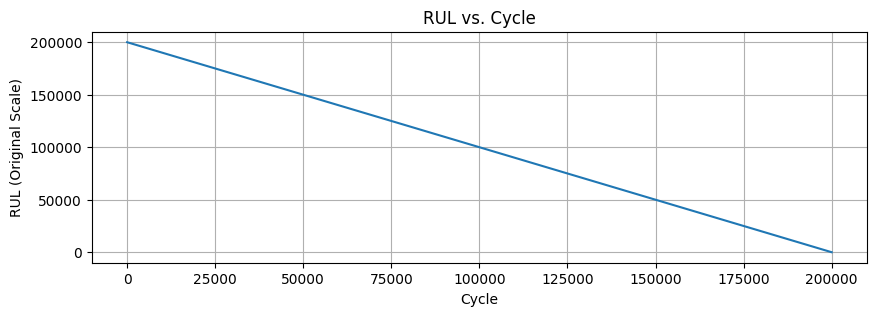

In [19]:
# --- 7. RUL Generation & 'bearing_id' ---
df_processed['bearing_id'] = 1 # Assuming single bearing for this sampled dataset
df_processed[target_col_name] = df_processed.groupby('bearing_id')['cycle'].transform(lambda x: x.max() - x)
print(f"\nRUL generated. Max RUL: {df_processed[target_col_name].max()}")

# Visualize RUL against cycle
plt.figure(figsize=(10, 3))
plt.plot(df_processed['cycle'], df_processed[target_col_name])
plt.xlabel('Cycle')
plt.ylabel('RUL (Original Scale)')
plt.title('RUL vs. Cycle')
plt.grid(True)
plt.show()

In [20]:

# --- 8. Scaling (Features and Target) ---
print("\n--- Scaling Final Features and Target Variable ---")
feature_scaler = MinMaxScaler()
df_processed[final_feature_cols] = feature_scaler.fit_transform(df_processed[final_feature_cols])

rul_scaler = MinMaxScaler()
df_processed[target_col_name] = rul_scaler.fit_transform(df_processed[[target_col_name]])
print(f"Target '{target_col_name}' scaled. Min: {df_processed[target_col_name].min()}, Max: {df_processed[target_col_name].max()}")

print("\n--- Data Head After All Preprocessing & Scaling ---")
print(df_processed[final_feature_cols + [target_col_name]].head())


--- Scaling Final Features and Target Variable ---
Target 'RUL' scaled. Min: 0.0, Max: 1.0

--- Data Head After All Preprocessing & Scaling ---
      abs_x_direction  abs_y_direction  bearing_temperature  env_temperature  \
0            0.142813         0.278029             0.454549         0.183074   
1200         0.917188         0.222799             0.454549         0.183074   
2400         0.422285         0.081994             0.454549         0.183074   
3600         0.432472         0.762988             0.454549         0.183074   
4800         0.453856         0.275047             0.454093         0.186486   

      log_abs_x_direction  log_abs_y_direction  log_bearing tem  x_direction  \
0                0.842605             0.891786         0.530508     0.418979   
1200             0.993009             0.873065         0.530508     0.957898   
2400             0.930282             0.788560         0.530508     0.706284   
3600             0.932210             0.977131        

In [21]:
# --- 9. Sequence Generation ---
sequence_length = 50
print(f"\n--- Creating sequences with length {sequence_length} ---")
def create_sequences(data, _feature_cols, _target_col, _sequence_length, bearing_id_col='bearing_id'):
    sequences_X_list, sequences_y_list = [], []
    for bid in data[bearing_id_col].unique():
        bearing_data = data[data[bearing_id_col] == bid]
        if len(bearing_data) < _sequence_length: continue
        if bearing_data[_feature_cols].isnull().values.any(): # Check on numpy values for speed
            raise ValueError(f"NaNs in feature data for bearing_id {bid}")
        features_values = bearing_data[_feature_cols].values
        target_values = bearing_data[_target_col].values
        for i in range(len(bearing_data) - _sequence_length + 1):
            seq_x = features_values[i : i + _sequence_length]
            if np.isnan(seq_x).any(): raise ValueError("NaN in seq_x")
            seq_y = target_values[i + _sequence_length - 1]
            sequences_X_list.append(seq_x)
            sequences_y_list.append(seq_y)
    return np.array(sequences_X_list), np.array(sequences_y_list)

X_data, y_data = create_sequences(df_processed, final_feature_cols, target_col_name, sequence_length)
if X_data.shape[0] == 0: raise ValueError("X_data empty after sequencing.")
print(f"Shape of X_data: {X_data.shape}, Shape of y_data: {y_data.shape}")
if np.isnan(X_data).any() or np.isnan(y_data).any(): raise ValueError("NaNs in X_data/y_data post sequencing.")


--- Creating sequences with length 50 ---
Shape of X_data: (199947, 50, 9), Shape of y_data: (199947,)


In [22]:

# --- 10. Data Splitting ---
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_data, y_data, test_size=0.20, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True # 0.25 of (1-0.20) = 0.20 of total
) # This makes train: 60%, val: 20%, test: 20%
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
if np.isnan(X_train).any() or np.isnan(y_train).any(): raise ValueError("NaNs in train split.")


Train: (119967, 50, 9), Val: (39990, 50, 9), Test: (39990, 50, 9)


In [23]:
# --- 11. Model Architecture (CNN-LSTM) ---
print("\n--- Building CNN-LSTM Model ---")
num_model_features = X_train.shape[2]
def build_cnnlstm_model(_sequence_length, _num_features):
    model = tf.keras.models.Sequential([ # CORRECTED
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(_sequence_length, _num_features), padding='same'),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(units=100, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.LSTM(units=50, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    return model

model = build_cnnlstm_model(sequence_length, num_model_features)
model.summary()


--- Building CNN-LSTM Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 50, 128)        │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 12, 100)        │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,441 (572.04 KB)

 Trainable params: 146,441 (572.04 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# --- 12. Model Compilation & Training ---
# Learning rate schedule can be beneficial
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000, # Adjust based on dataset size and epochs
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule) # CORRECTED

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1) # CORRECTED
model_ultimate_path = '/content/drive/MyDrive/best_model.keras'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_ultimate_path, monitor='val_loss', save_best_only=True, verbose=1) # CORRECTED

batch_size = 64
epochs = 30

print("\n--- Starting Ultimate Model Training ---")
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


--- Starting Ultimate Model Training ---
Epoch 1/30
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0387 - rmse: 0.0614
Epoch 1: val_loss improved from inf to 0.00316, saving model to /content/drive/MyDrive/best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0044 - mae: 0.0387 - rmse: 0.0614 - val_loss: 0.0032 - val_mae: 0.0321 - val_rmse: 0.0507
Epoch 2/30
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0369 - rmse: 0.0573
Epoch 2: val_loss improved from 0.00316 to 0.00243, saving model to /content/drive/MyDrive/best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 0.0039 - mae: 0.0369 - rmse: 0.0573 - val_loss: 0.0024 - val_mae: 0.0294 - val_rmse: 0.0440
Epoch 3/30
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0376 - rmse: 0.0589
Epoch 3: val_loss did not improve from 0.00243
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0041 - mae: 0.0376 - rmse: 0.0589 - val_loss: 0.0025 - val


--- Evaluating Ultimate Model ---


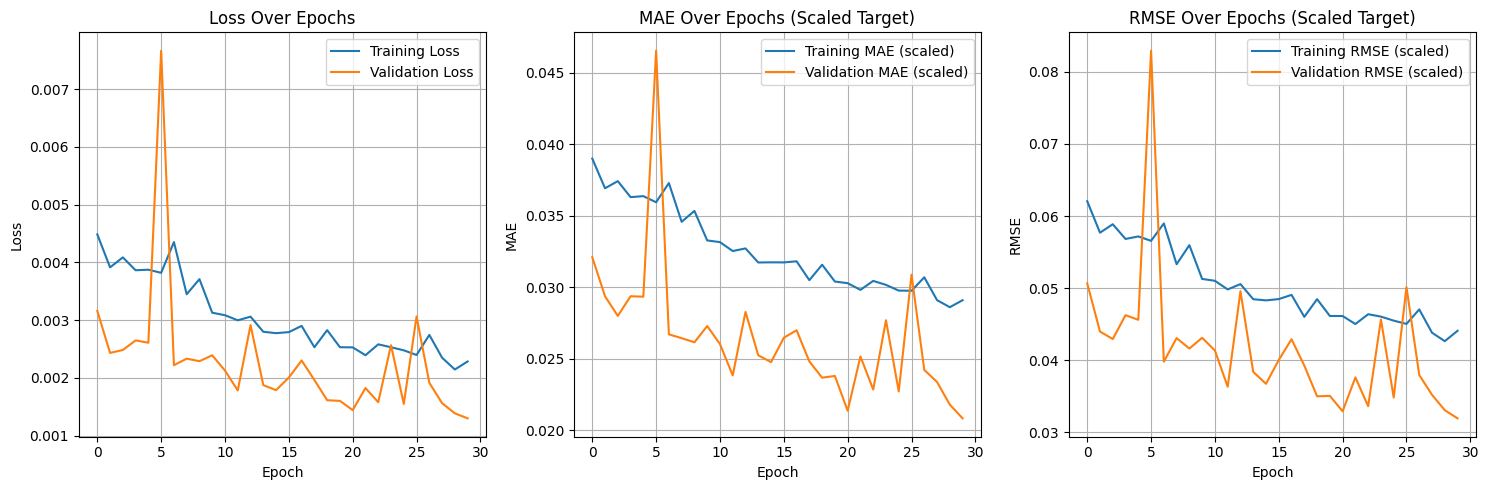

In [31]:

# --- 13. Model Evaluation & Rich Visualizations ---
print("\n--- Evaluating Ultimate Model ---")
best_model = tf.keras.models.load_model(model_ultimate_path)

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE (scaled)')
plt.plot(history.history['val_mae'], label='Validation MAE (scaled)')
plt.title('MAE Over Epochs (Scaled Target)')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend(); plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['rmse'], label='Training RMSE (scaled)')
plt.plot(history.history['val_rmse'], label='Validation RMSE (scaled)')
plt.title('RMSE Over Epochs (Scaled Target)')
plt.xlabel('Epoch'); plt.ylabel('RMSE'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


In [32]:
# Predictions
y_pred_scaled_test = best_model.predict(X_test)
y_pred_test_orig_scale = rul_scaler.inverse_transform(y_pred_scaled_test)
y_test_orig_scale = rul_scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics on original scale
r2_orig = r2_score(y_test_orig_scale, y_pred_test_orig_scale)
mse_orig = mean_squared_error(y_test_orig_scale, y_pred_test_orig_scale)
mae_orig = mean_absolute_error(y_test_orig_scale, y_pred_test_orig_scale)
rmse_orig = np.sqrt(mse_orig)

print(f"\nTest Set Performance (Original RUL Scale):")
print(f"  R² Score: {r2_orig:.4f}")
print(f"  MSE: {mse_orig:.2f}")
print(f"  RMSE: {rmse_orig:.2f} (cycles)")
print(f"  MAE: {mae_orig:.2f} (cycles)")


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Test Set Performance (Original RUL Scale):
  R² Score: 0.9881
  MSE: 39612746.00
  RMSE: 6293.87 (cycles)
  MAE: 4129.31 (cycles)


SUCCESS: R² score (0.9881) meets target (> 0.8)!


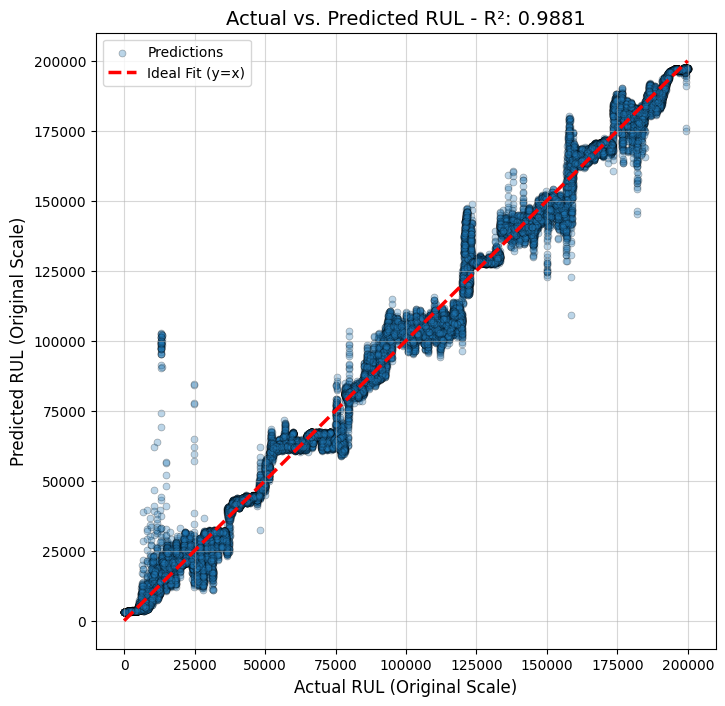

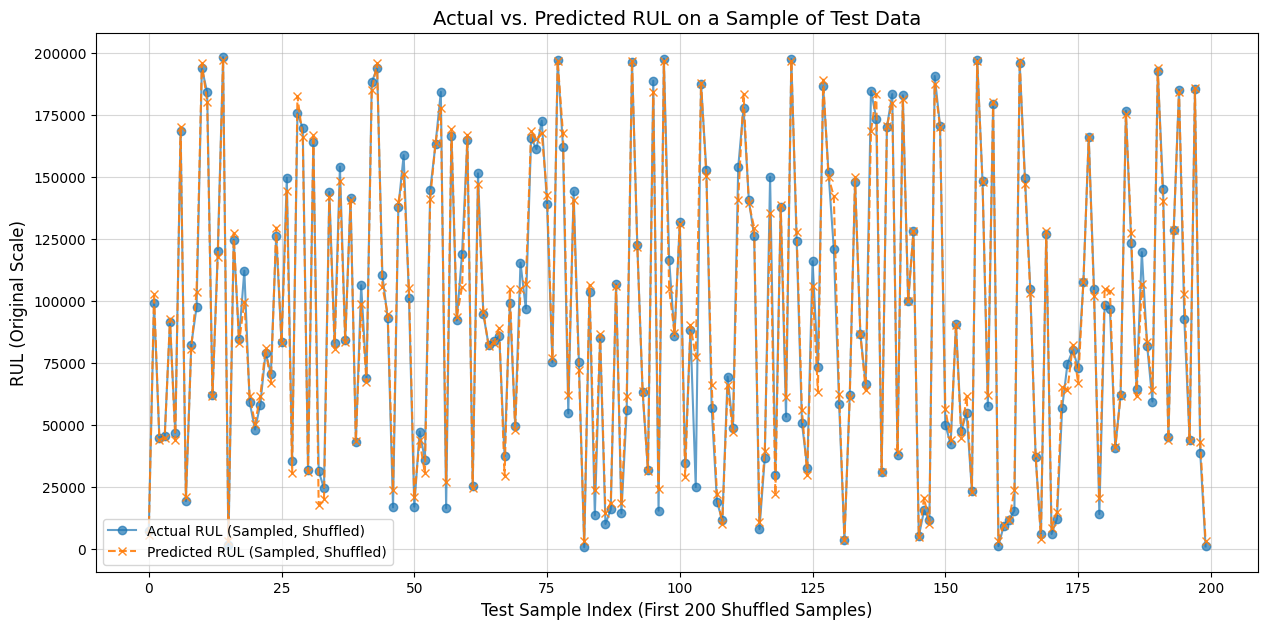

In [33]:
if r2_orig > 0.8: print(f"SUCCESS: R² score ({r2_orig:.4f}) meets target (> 0.8)!")
else: print(f"INFO: R² score ({r2_orig:.4f}). Consider further tuning.")

# Scatter plot: Actual vs. Predicted RUL
plt.figure(figsize=(8, 8))
plt.scatter(y_test_orig_scale, y_pred_test_orig_scale, alpha=0.3, s=25, edgecolors='k', linewidth=0.5, label="Predictions")
plt.plot([y_test_orig_scale.min(), y_test_orig_scale.max()],
         [y_test_orig_scale.min(), y_test_orig_scale.max()],
         'r--', lw=2.5, label='Ideal Fit (y=x)')
plt.xlabel("Actual RUL (Original Scale)", fontsize=12)
plt.ylabel("Predicted RUL (Original Scale)", fontsize=12)
plt.title(f"Actual vs. Predicted RUL - R²: {r2_orig:.4f}", fontsize=14)
plt.legend(fontsize=10); plt.grid(alpha=0.5); plt.show()

# Line plot: Actual vs. Predicted RUL for a sample
num_plot_samples = min(200, len(y_test_orig_scale)) # Ensure not to exceed test set size
plt.figure(figsize=(15, 7))
indices_to_plot = np.arange(num_plot_samples) # Plotting first N samples from shuffled test set
plt.plot(indices_to_plot, y_test_orig_scale[:num_plot_samples], label='Actual RUL (Sampled, Shuffled)', marker='o', linestyle='-', markersize=6, alpha=0.7)
plt.plot(indices_to_plot, y_pred_test_orig_scale[:num_plot_samples], label='Predicted RUL (Sampled, Shuffled)', marker='x', linestyle='--', markersize=6, alpha=0.9)
plt.xlabel(f"Test Sample Index (First {num_plot_samples} Shuffled Samples)", fontsize=12)
plt.ylabel("RUL (Original Scale)", fontsize=12)
plt.title("Actual vs. Predicted RUL on a Sample of Test Data", fontsize=14)
plt.legend(fontsize=10); plt.grid(alpha=0.5); plt.show()

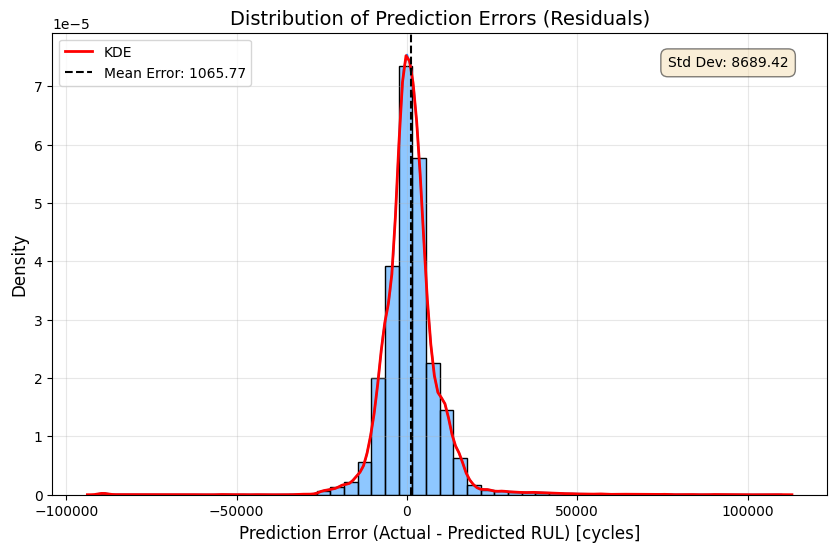

In [28]:

# Distribution of Prediction Errors (Residuals)
residuals = (y_test_orig_scale - y_pred_test_orig_scale).flatten()
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50, color='dodgerblue', stat="density")
sns.kdeplot(residuals, color='red', linewidth=2, label="KDE") # Overlay KDE
plt.xlabel("Prediction Error (Actual - Predicted RUL) [cycles]", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Prediction Errors (Residuals)", fontsize=14)
mean_res, std_res = residuals.mean(), residuals.std()
plt.axvline(mean_res, color='k', linestyle='dashed', linewidth=1.5, label=f'Mean Error: {mean_res:.2f}')
plt.text(0.95, 0.95, f'Std Dev: {std_res:.2f}', ha='right', va='top', transform=plt.gca().transAxes, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
plt.legend(fontsize=10); plt.grid(alpha=0.3); plt.show()


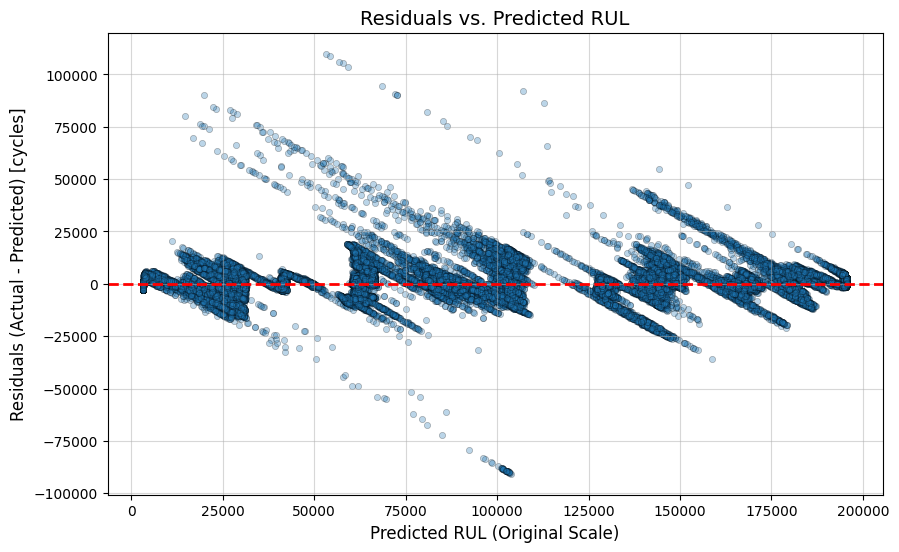


Mean of Residuals: 1065.77 cycles
Standard Deviation of Residuals: 8689.42 cycles

--- Pipeline Complete ---


In [29]:
# Residuals vs. Predicted values plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_orig_scale, residuals, alpha=0.3, s=20, edgecolors='k', linewidth=0.5)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted RUL (Original Scale)", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted) [cycles]", fontsize=12)
plt.title("Residuals vs. Predicted RUL", fontsize=14)
plt.grid(alpha=0.5); plt.show()

print(f"\nMean of Residuals: {mean_res:.2f} cycles")
print(f"Standard Deviation of Residuals: {std_res:.2f} cycles")
print("\n--- Pipeline Complete ---")